# Voice translator with Azure AI using Speech to Text, Azure AI Translator and Text to Speech

<img src="https://github.com/retkowsky/azure-ai-translator/blob/main/webapp4.jpg?raw=true">

In [1]:
import azure.cognitiveservices.speech as speechsdk
import datetime
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import random
import sys
import wave

from azure.ai.translation.text import TextTranslationClient
from azure.core.credentials import AzureKeyCredential
from azure.ai.translation.text.models import InputTextItem
from dotenv import load_dotenv
from IPython.display import Audio
from openai import AzureOpenAI

In [2]:
print(f"Python version is: {sys.version}")

Python version is: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 05-Mar-2025 11:27:10


## 1. Settings

In [4]:
def check_openai_version():
    """
    Check OpenAI version
    """
    try:
        installed_version = openai.__version__
        version_number = float(installed_version.split('.')[0])

    except (AttributeError, ValueError):
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}\n")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")

    else:
        print(f"[OK] OpenAI version {installed_version} is greater than version 1.0.0")

In [5]:
check_openai_version()

Installed OpenAI version: 1.61.1

[OK] OpenAI version 1.61.1 is greater than version 1.0.0


In [6]:
load_dotenv("azure.env")

# Azure AI Translator
azure_ai_translator_key = os.getenv("AZURE_AI_TRANSLATION_KEY")
azure_ai_translator_region = os.getenv("AZURE_AI_TRANSLATION_REGION")

# Azure OpenAI Whisper model
openai.api_base = os.getenv("AOAI_ENDPOINT")
openai.api_key = os.getenv("AOAI_KEY")
openai.api_version = os.getenv("AOAI_VERSION")
openai.api_type = os.getenv("AOAI_TYPE")
deployment_id = os.getenv("AOAI_DEPLOYMENT")  # Whisper deployed name model
model = os.getenv("AOAI_MODEL")  # Whisper model

# Azure Speech Services
azure_speech_key = os.getenv("azure_speech_key")
azure_speech_region = os.getenv("azure_speech_region")

In [7]:
audio_dir = "audio"

os.makedirs(audio_dir, exist_ok=True)

## 2. Speech to text with Azure OpenAI Whisper

In [8]:
# Azure OpenAI client for Whisper
aoai_client = AzureOpenAI(
    api_key=openai.api_key,
    api_version=openai.api_version,
    azure_endpoint=openai.api_base,
)

In [9]:
def azure_speech_to_text(audio_filename):
    """
    Transcribes speech from an audio file using Azure Speech to Text service.
    Input: audio file
    Output: text transcript
    """
    try:
        with open(audio_filename, "rb") as audio_file:
            result = aoai_client.audio.transcriptions.create(
                file=audio_file,
                model=deployment_id,
            )
            return result.text

    except Exception as e:
        print(f"[Error] Speech to text error: {e}")
        return None

### Test

In [10]:
sample_audio = "sample.wav"

!ls $sample_audio -lh

-rwxrwxrwx 1 root root 74K Apr 19  2024 sample.wav


In [11]:
print(f"Playing audio file {sample_audio}")
Audio(sample_audio, autoplay=False)

Playing audio file sample.wav


In [12]:
def amplitude_plot(audio_file):
    """
    Get amplitude plot from a .wav audio file
    """
    with wave.open(audio_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        signal = np.frombuffer(frames, dtype=np.int16)
        frame_rate = wf.getframerate()
        time_values = np.arange(0, num_frames) / frame_rate
        # Plot
        plt.figure(figsize=(12, 3))
        plt.plot(time_values, signal, color='blue')
        plt.title(f'Amplitude of {audio_file}')
        plt.xlabel('Time in seconds')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.show()

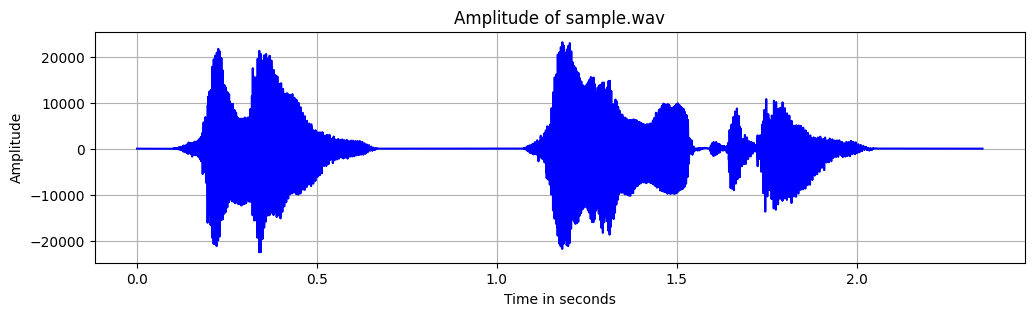

In [13]:
amplitude_plot(sample_audio)

In [14]:
# Test
results = azure_speech_to_text(sample_audio)
print(results)

Hello. How are you today?


## 3. Languages supported

In [15]:
# Translation client
credential = AzureKeyCredential(azure_ai_translator_key)

translator_client = TextTranslationClient(
    credential=credential,
    region=azure_ai_translator_region
)

In [16]:
def print_languages(label, languages):
        """
        Print supported languages of Azure AI Translator
        """
        print("\033[1;31;34m")
        
        if languages is not None:
            print(f"Number of supported {label} languages = {len(languages)}\n")
            print(f"{label.capitalize()} languages:")

            for idx, (key, value) in enumerate(languages.items(), start=1):
                print(f"{idx:03}\t{key:10} {value.name} ({value.native_name})")

        else:
            print(f"No supported {label} languages.")

In [17]:
response = translator_client.get_supported_languages()

In [18]:
print_languages("translation", response.translation)


Number of supported translation languages = 135

Translation languages:
001	af         Afrikaans (Afrikaans)
002	am         Amharic (አማርኛ)
003	ar         Arabic (العربية)
004	as         Assamese (অসমীয়া)
005	az         Azerbaijani (Azərbaycan)
006	ba         Bashkir (Bashkir)
007	bg         Bulgarian (Български)
008	bho        Bhojpuri (भोजपुरी)
009	bn         Bangla (বাংলা)
010	bo         Tibetan (བོད་སྐད་)
011	brx        Bodo (बड़ो)
012	bs         Bosnian (Bosanski)
013	ca         Catalan (Català)
014	cs         Czech (Čeština)
015	cy         Welsh (Cymraeg)
016	da         Danish (Dansk)
017	de         German (Deutsch)
018	doi        Dogri (डोगरी)
019	dsb        Lower Sorbian (Dolnoserbšćina)
020	dv         Divehi (ދިވެހިބަސް)
021	el         Greek (Ελληνικά)
022	en         English (English)
023	es         Spanish (Español)
024	et         Estonian (Eesti)
025	eu         Basque (Euskara)
026	fa         Persian (فارسی)
027	fi         Finnish (Suomi)
028	fil        Filipino (Filipino)


In [19]:
print_languages("transliteration", response.transliteration)


Number of supported transliteration languages = 42

Transliteration languages:
001	ar         Arabic (العربية)
002	as         Assamese (অসমীয়া)
003	be         Belarusian (беларуская)
004	bg         Bulgarian (Български)
005	bn         Bangla (বাংলা)
006	brx        Bodo (बड़ो)
007	el         Greek (Ελληνικά)
008	fa         Persian (فارسی)
009	gom        Konkani (कोंकणी)
010	gu         Gujarati (ગુજરાતી)
011	he         Hebrew (עברית)
012	hi         Hindi (हिन्दी)
013	ja         Japanese (日本語)
014	kk         Kazakh (Қазақ Тілі)
015	kn         Kannada (ಕನ್ನಡ)
016	ko         Korean (한국어)
017	ks         Kashmiri (کٲشُر)
018	ky         Kyrgyz (Кыргызча)
019	mai        Maithili (मैथिली)
020	mk         Macedonian (Македонски)
021	ml         Malayalam (മലയാളം)
022	mn-Cyrl    Mongolian (Cyrillic) (Монгол)
023	mni        Manipuri (ꯃꯩꯇꯩꯂꯣꯟ)
024	mr         Marathi (मराठी)
025	ne         Nepali (नेपाली)
026	or         Odia (ଓଡ଼ିଆ)
027	pa         Punjabi (ਪੰਜਾਬੀ)
028	ru         Russian (Русский)
029

In [20]:
print_languages("dictionary", response.dictionary)


Number of supported dictionary languages = 50

Dictionary languages:
001	af         Afrikaans (Afrikaans)
002	ar         Arabic (العربية)
003	bg         Bulgarian (Български)
004	bn         Bangla (বাংলা)
005	bs         Bosnian (Bosanski)
006	ca         Catalan (Català)
007	cs         Czech (Čeština)
008	cy         Welsh (Cymraeg)
009	da         Danish (Dansk)
010	de         German (Deutsch)
011	el         Greek (Ελληνικά)
012	en         English (English)
013	es         Spanish (Español)
014	et         Estonian (Eesti)
015	fa         Persian (فارسی)
016	fi         Finnish (Suomi)
017	fr         French (Français)
018	he         Hebrew (עברית)
019	hi         Hindi (हिन्दी)
020	hr         Croatian (Hrvatski)
021	hu         Hungarian (Magyar)
022	id         Indonesian (Indonesia)
023	is         Icelandic (Íslenska)
024	it         Italian (Italiano)
025	ja         Japanese (日本語)
026	ko         Korean (한국어)
027	lt         Lithuanian (Lietuvių)
028	lv         Latvian (Latviešu)
029	ms       

In [21]:
lang_list = []

if response.translation is not None:
    for key, value in response.translation.items():
        lang_list.append(
            {
                "Language_Code": key,
                "Language_Name": value.name,
                "Native_Name": value.native_name,
            }
        )

df_languages = pd.DataFrame(lang_list)
df_languages

,Language_Code,Language_Name,Native_Name
0,af,Afrikaans,Afrikaans
1,am,Amharic,አማርኛ
2,ar,Arabic,العربية
3,as,Assamese,অসমীয়া
4,az,Azerbaijani,Azərbaycan
...,...,...,...
130,yua,Yucatec Maya,Yucatec Maya
131,yue,Cantonese (Traditional),粵語 (繁體)
132,zh-Hans,Chinese Simplified,中文 (简体)
133,zh-Hant,Chinese Traditional,繁體中文 (繁體)


In [22]:
print("Azure AI Translator supported languages")
print("\033[1;31;34m")
print(df_languages.to_string())

Azure AI Translator supported languages

    Language_Code            Language_Name           Native_Name
0              af                Afrikaans             Afrikaans
1              am                  Amharic                  አማርኛ
2              ar                   Arabic               العربية
3              as                 Assamese               অসমীয়া
4              az              Azerbaijani            Azərbaycan
5              ba                  Bashkir               Bashkir
6              bg                Bulgarian             Български
7             bho                 Bhojpuri               भोजपुरी
8              bn                   Bangla                 বাংলা
9              bo                  Tibetan              བོད་སྐད་
10            brx                     Bodo                  बड़ो
11             bs                  Bosnian              Bosanski
12             ca                  Catalan                Català
13             cs                    Czech       

In [23]:
excel_file = "azure_ai_translator_languages.xlsx"

df_languages.to_excel(excel_file)
!ls $excel_file -lh

-rwxrwxrwx 1 root root 11K Mar  5 11:27 azure_ai_translator_languages.xlsx


In [24]:
# Get dict from dataframe
language_dict = df_languages.set_index("Language_Code")["Language_Name"].to_dict()
# Full names list
language_full_names = list(language_dict.values())
# Sort
language_full_names.sort()
# Language codes list
language_codes = list(language_dict.keys())
# Sort
language_codes.sort()
# Creation of dict
reverse_language_names = {v: k for k, v in language_dict.items()}

In [25]:
print(f"Number of supported languages with Azure AI Translator = {len(reverse_language_names)}")

Number of supported languages with Azure AI Translator = 135


In [26]:
print(language_codes)

['af', 'am', 'ar', 'as', 'az', 'ba', 'bg', 'bho', 'bn', 'bo', 'brx', 'bs', 'ca', 'cs', 'cy', 'da', 'de', 'doi', 'dsb', 'dv', 'el', 'en', 'es', 'et', 'eu', 'fa', 'fi', 'fil', 'fj', 'fo', 'fr', 'fr-CA', 'ga', 'gl', 'gom', 'gu', 'ha', 'he', 'hi', 'hne', 'hr', 'hsb', 'ht', 'hu', 'hy', 'id', 'ig', 'ikt', 'is', 'it', 'iu', 'iu-Latn', 'ja', 'ka', 'kk', 'km', 'kmr', 'kn', 'ko', 'ks', 'ku', 'ky', 'ln', 'lo', 'lt', 'lug', 'lv', 'lzh', 'mai', 'mg', 'mi', 'mk', 'ml', 'mn-Cyrl', 'mn-Mong', 'mni', 'mr', 'ms', 'mt', 'mww', 'my', 'nb', 'ne', 'nl', 'nso', 'nya', 'or', 'otq', 'pa', 'pl', 'prs', 'ps', 'pt', 'pt-PT', 'ro', 'ru', 'run', 'rw', 'sd', 'si', 'sk', 'sl', 'sm', 'sn', 'so', 'sq', 'sr-Cyrl', 'sr-Latn', 'st', 'sv', 'sw', 'ta', 'te', 'th', 'ti', 'tk', 'tlh-Latn', 'tlh-Piqd', 'tn', 'to', 'tr', 'tt', 'ty', 'ug', 'uk', 'ur', 'uz', 'vi', 'xh', 'yo', 'yua', 'yue', 'zh-Hans', 'zh-Hant', 'zu']


In [27]:
print(reverse_language_names)

{'Afrikaans': 'af', 'Amharic': 'am', 'Arabic': 'ar', 'Assamese': 'as', 'Azerbaijani': 'az', 'Bashkir': 'ba', 'Bulgarian': 'bg', 'Bhojpuri': 'bho', 'Bangla': 'bn', 'Tibetan': 'bo', 'Bodo': 'brx', 'Bosnian': 'bs', 'Catalan': 'ca', 'Czech': 'cs', 'Welsh': 'cy', 'Danish': 'da', 'German': 'de', 'Dogri': 'doi', 'Lower Sorbian': 'dsb', 'Divehi': 'dv', 'Greek': 'el', 'English': 'en', 'Spanish': 'es', 'Estonian': 'et', 'Basque': 'eu', 'Persian': 'fa', 'Finnish': 'fi', 'Filipino': 'fil', 'Fijian': 'fj', 'Faroese': 'fo', 'French': 'fr', 'French (Canada)': 'fr-CA', 'Irish': 'ga', 'Galician': 'gl', 'Konkani': 'gom', 'Gujarati': 'gu', 'Hausa': 'ha', 'Hebrew': 'he', 'Hindi': 'hi', 'Chhattisgarhi': 'hne', 'Croatian': 'hr', 'Upper Sorbian': 'hsb', 'Haitian Creole': 'ht', 'Hungarian': 'hu', 'Armenian': 'hy', 'Indonesian': 'id', 'Igbo': 'ig', 'Inuinnaqtun': 'ikt', 'Icelandic': 'is', 'Italian': 'it', 'Inuktitut': 'iu', 'Inuktitut (Latin)': 'iu-Latn', 'Japanese': 'ja', 'Georgian': 'ka', 'Kazakh': 'kk', 'Kh

### 3.1 Function

In [28]:
def get_language_code(language_name):
    """
    Function to get language code by language name
    Input: language full name
    Output: language code name
    """
    return reverse_language_names.get(language_name)

#### Tests

In [29]:
# Test
print(get_language_code("English"))

en


In [30]:
# Test
print(get_language_code("Italian"))

it


## 4.1 Translation

In [31]:
def azure_ai_translator(mytext, source_lang, target_lang):
    """
    Translates text from one language to another using Azure AI Translator.
    
    Args:
        mytext (str): The text to be translated.
        source_lang (str): The full name of the source language.
        target_lang (str): The full name of the target language.
    
    Returns:
        str: The translated text, or None if an error occurs.
    """
    try:
        credential = AzureKeyCredential(azure_ai_translator_key)
        
        text_translator = TextTranslationClient(credential=credential, region=azure_ai_translator_region)
        input_text_elements = [mytext]

        # Get language codes
        source_lang_code = get_language_code(source_lang)
        target_lang_code = [get_language_code(target_lang)]
        
        # Response
        response = text_translator.translate(body=input_text_elements,
                                             to_language=target_lang_code)
        translation = response[0] if response else None

        if translation:
            detected_language = translation.detected_language
            if detected_language:
                print(f"Detected languages of the input text: {detected_language.language} with score = {detected_language.score}.")
            for translated_text in translation.translations:
                print(f"\nText to translate to: '{translated_text.to}'")
            return translated_text.text

    except HttpResponseError as exception:
        if exception.error is not None:
            print(f"Error Code: {exception.error.code}")
            print(f"Message: {exception.error.message}")

### Tests

In [32]:
# Quick Test
result = azure_ai_translator("Welcome to this presentation", "English", "French")
print(result)

Detected languages of the input text: en with score = 1.0.

Text to translate to: 'fr'
Bienvenue à cette présentation


In [33]:
# Quick Test
result = azure_ai_translator("Bonjour. Nous sommes le 10 mai 2024", "French", "Italian")
print(result)

Detected languages of the input text: fr with score = 1.0.

Text to translate to: 'it'
Ciao. È il 10 maggio 2024


### 5. Text to Speech

> List of Azure neural voices:
https://learn.microsoft.com/en-us/azure/ai-services/speech-service/language-support?tabs=tts#prebuilt-neural-voices

In [34]:
# Some multilingual neural voices
neural_voices = [
    "en-US-AndrewMultilingualNeural",
    "en-US-AvaMultilingualNeural",
]

In [35]:
def azure_text_to_speech(text):
    """
    Text to Speech with Azure Speech Services
    Input: Text
    Output: Audio file
    """
    dt = str(datetime.datetime.now().strftime('%d%b%Y_%H%M%S_%f'))
    
    # Parameters
    output_file = f"{audio_dir}/translated_audio_{dt}.wav"
    neural_voice = random.choice(neural_voices)  # Will take a random voice from the list
    
    # Configuration of the neural voice
    speech_config = speechsdk.SpeechConfig(subscription=azure_speech_key, region=azure_speech_region)
    speech_config.speech_synthesis_voice_name=neural_voice
    file_config = speechsdk.audio.AudioOutputConfig(filename=output_file)
    
    # Speech Synthesizer
    speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config, audio_config=file_config)
    speech_synthesis_result = speech_synthesizer.speak_text_async(text).get()

    if speech_synthesis_result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
        print("Done\n")
        print("[Input] {}".format(text))
        print(f"[Result] File {output_file} is created:")
        !ls $output_file -lh
    
    elif speech_synthesis_result.reason == speechsdk.ResultReason.Canceled:
        cancellation_details = speech_synthesis_result.cancellation_details
        print("Speech synthesis canceled: {}".format(cancellation_details.reason))
        if cancellation_details.reason == speechsdk.CancellationReason.Error:
            if cancellation_details.error_details:
                print("Error details: {}".format(cancellation_details.error_details))
    
    return output_file

### Tests

In [36]:
# Test 1
audiofile = azure_text_to_speech("Bonjour. Bienvenue à cette présentation.")

Done

[Input] Bonjour. Bienvenue à cette présentation.
[Result] File audio/translated_audio_05Mar2025_112727_521587.wav is created:
-rwxrwxrwx 1 root root 97K Mar  5 11:27 audio/translated_audio_05Mar2025_112727_521587.wav


In [37]:
print(f"Playing audio file {audiofile}")
Audio(audiofile, autoplay=False)

Playing audio file audio/translated_audio_05Mar2025_112727_521587.wav


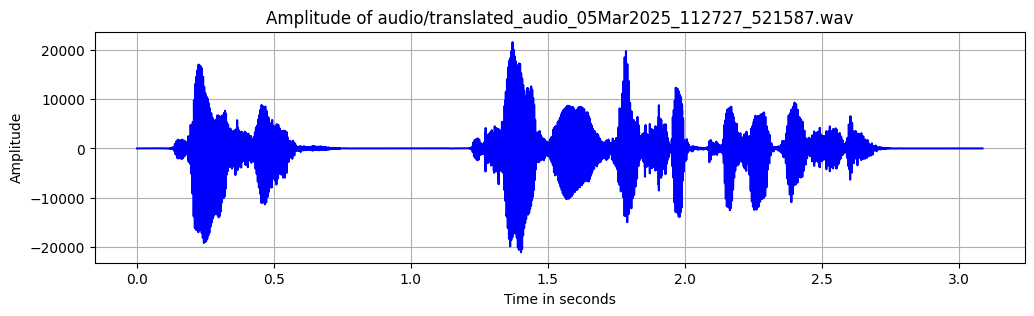

In [38]:
amplitude_plot(audiofile)

In [39]:
# Test 2
audiofile = azure_text_to_speech("Hello. Good to see you")

Done

[Input] Hello. Good to see you
[Result] File audio/translated_audio_05Mar2025_112732_746993.wav is created:
-rwxrwxrwx 1 root root 56K Mar  5 11:27 audio/translated_audio_05Mar2025_112732_746993.wav


In [40]:
print(f"Playing audio file {audiofile}")
Audio(audiofile, autoplay=False)

Playing audio file audio/translated_audio_05Mar2025_112732_746993.wav


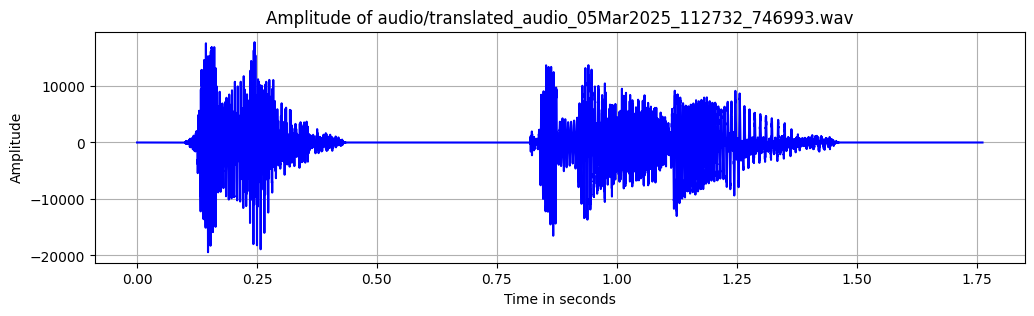

In [41]:
amplitude_plot(audiofile)

## 6. Webapp

### Function

In [42]:
def azure_tts_translation_tts(input_audio_file, source_lang, target_lang):
    """
    Speech to Text and translation using the STT transcript
    Inputs: audio file, source language and target language
    Outputs: input audio file, transcript, translation and output audio file
    """
    try:
        # 1. Speech to text result
        transcript = azure_speech_to_text(input_audio_file)
    except Exception as e:
        print(f"Speech to Text error: {e}")
        return None, None, None, None

    try:
        # 2. Translation of the Speech to text result
        translation = azure_ai_translator(transcript, source_lang, target_lang)
    except Exception as e:
        print(f"Text Translation error: {e}")
        return input_audio_file, transcript, None, None

    try:
        # 3. Text to speech
        output_audio_file = azure_text_to_speech(translation)
    except Exception as e:
        print(f"Text to Speech error: {e}")
        return input_audio_file, transcript, translation, None

    return input_audio_file, transcript, translation, output_audio_file


### Tests

In [43]:
# Quick test
input_audio_file, transcript, translation, output_audio_file = azure_tts_translation_tts("sample.wav", "English", "Japanese")

Detected languages of the input text: en with score = 1.0.

Text to translate to: 'ja'
Done

[Input] こんにちは。お元気ですか。
[Result] File audio/translated_audio_05Mar2025_112744_161211.wav is created:
-rwxrwxrwx 1 root root 74K Mar  5 11:27 audio/translated_audio_05Mar2025_112744_161211.wav


In [44]:
print(f"Playing audio file {output_audio_file}")
Audio(output_audio_file, autoplay=False)

Playing audio file audio/translated_audio_05Mar2025_112744_161211.wav


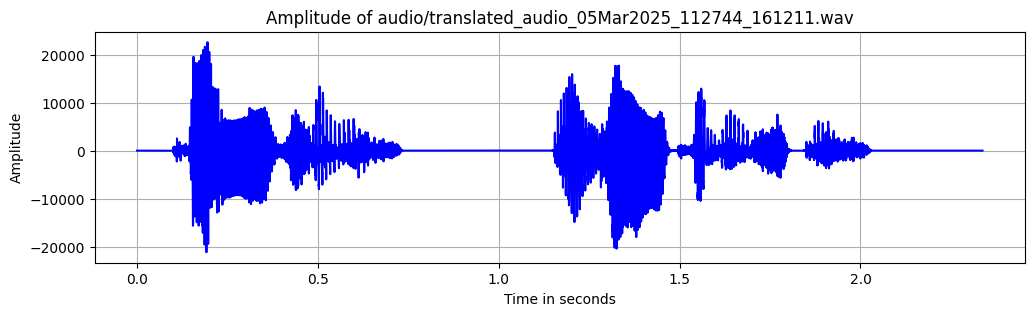

In [45]:
amplitude_plot(output_audio_file)

In [46]:
# Quick test
input_audio_file, transcript, translation, output_audio_file = azure_tts_translation_tts("sample.wav", "English", "Italian")

Detected languages of the input text: en with score = 1.0.

Text to translate to: 'it'
Done

[Input] Ciao. Come stai oggi?
[Result] File audio/translated_audio_05Mar2025_112752_533655.wav is created:
-rwxrwxrwx 1 root root 66K Mar  5 11:27 audio/translated_audio_05Mar2025_112752_533655.wav


In [47]:
print(f"Playing audio file {output_audio_file}")
Audio(output_audio_file, autoplay=False)

Playing audio file audio/translated_audio_05Mar2025_112752_533655.wav


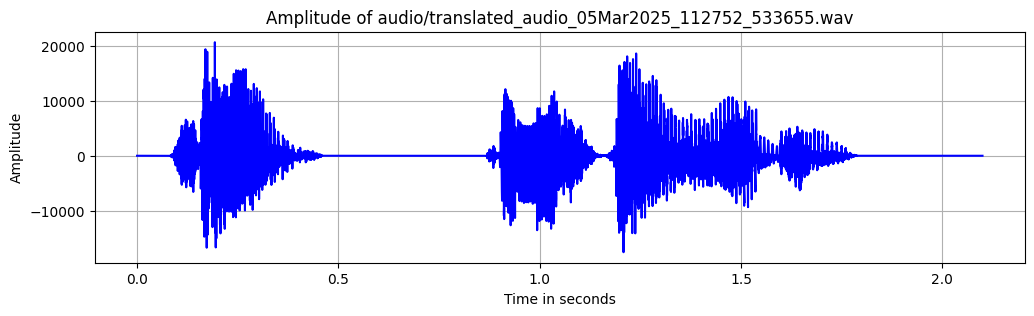

In [48]:
amplitude_plot(output_audio_file)

### Webapp

In [49]:
image_url = "https://github.com/retkowsky/azure-ai-translator/blob/main/sttranslatelogo.jpg?raw=true"
logo = "<center> <img src= {} width=200px></center>".format(image_url)
title = "Vocal translator using Azure AI services"
theme = "JohnSmith9982/small_and_pretty"  # https://huggingface.co/spaces/gradio/theme-gallery


vocaltranslator_webapp = gr.Interface(
    # Function to use
    azure_tts_translation_tts,
    # Webapp inputs
    inputs=[
        gr.components.Audio(
            sources="microphone", 
            type="filepath",
            label="1. Record your voice"
        ),
        gr.components.Dropdown(
            label="2. Select the audio source language",
            value="French",
            choices=language_full_names
        ),
        gr.components.Dropdown(
            label="3. Select the target language",
            value="English",
            choices=language_full_names
        ),
    ],
    # Webapp outputs
    outputs=[
        gr.Audio(label="1. Your speech"),
        gr.Text(label="2. Your text",
                show_copy_button = True,
                show_label = True),
        gr.Text(label="3. Translated text",
                show_copy_button = True,
                show_label = True),
        gr.Audio(label="4. Translated audio file"),
    ],
    # Webapp options
    cache_examples=False,
    title=title,
    description=logo,
    theme=theme,
)

vocaltranslator_webapp.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://5a6ce7b8ff8c3b2fa8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Detected languages of the input text: fr with score = 1.0.

Text to translate to: 'en'
Done

[Input] Hello, welcome to this presentation.
[Result] File audio/translated_audio_05Mar2025_112812_552194.wav is created:
-rwxrwxrwx 1 root root 96K Mar  5 11:28 audio/translated_audio_05Mar2025_112812_552194.wav
